In [131]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Sydney Liveability Analysis

## Group - 5  F10Adv-01

In [132]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [133]:
sa2_data = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

In [134]:
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

In [135]:
school_catchments_future = gpd.read_file("school_catchments/catchments_future.shp")

In [136]:
school_catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

In [137]:
school_catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

In [138]:
neighbourhoods = pd.read_csv('Neighbourhoods.csv')


In [139]:
BusinessStats = pd.read_csv('BusinessStats.csv')

In [140]:
Playgrounds_json = json.load(open('Playgrounds.geojson'))

Playgrounds_DataFrame = pd.DataFrame(Playgrounds_json["features"])
Playgrounds_pandas_data=[]
for index, row in Playgrounds_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Name"]]
    Playgrounds_pandas_data.append(append_row)
    
Playgrounds = pd.DataFrame(Playgrounds_pandas_data, columns = ['X', 'Y','Name'])
Playgrounds['geom'] = gpd.points_from_xy(Playgrounds.X, Playgrounds.Y)  # creating the geometry column
Playgrounds = Playgrounds.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

In [141]:
Lights_json = json.load(open('Lights.geojson'))
Lights_DataFrame = pd.DataFrame(Lights_json["features"])
Lights_pandas_data=[]
for index, row in Lights_DataFrame.iterrows():
    append_row = [row["geometry"]["coordinates"][0],row["geometry"]["coordinates"][1],row["properties"]["Location"]]
    Lights_pandas_data.append(append_row)
    
Lights = pd.DataFrame(Lights_pandas_data, columns = ['X', 'Y','Location'])
Lights['geom'] = gpd.points_from_xy(Lights.X, Lights.Y)  # creating the geometry column
Lights = Lights.drop(columns=['X', 'Y'])  # removing the old latitude/longitude fields

In [142]:
sa2_data = sa2_data.drop(sa2_data[(sa2_data['SA4_NAME16'].str.contains("No usual address", case=False)) |
                                  (sa2_data['SA4_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False)) |
                         sa2_data['SA3_NAME16'].str.contains("No usual address", case=False) |
                         sa2_data['SA3_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['SA2_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['SA2_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("No usual address", case=False) | 
                         sa2_data['GCC_NAME16'].str.contains("Migratory - Offshore - Shipping", case=False) |
                         sa2_data['GCC_NAME16'].str.contains("Rest of", case=False)].index
                        )

sa2_data = sa2_data[sa2_data['GCC_NAME16']=='Greater Sydney'] 

In [143]:
neighbourhoods = neighbourhoods.drop(neighbourhoods[neighbourhoods.isnull().T.any()].index)


In [144]:
for index, row in neighbourhoods.iterrows():
    old_value = row['population']
    old_value_split = str(row['population']).split(",")
    new_value = ""
    for i in old_value_split :
        new_value = new_value+i
    neighbourhoods['population'] = neighbourhoods['population'].replace([old_value],int(new_value))

In [145]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [146]:
db, conn = pgconnect(credentials)

Connected successfully.


In [147]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [148]:
srid = 4326
Playgrounds['geom'] = Playgrounds['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
Lights['geom'] = Lights['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [149]:
sa2_data = sa2_data[['SA2_MAIN16', 'SA2_NAME16','SA3_NAME16','AREASQKM16','geometry']].copy()
break_and_enter = break_and_enter[['OBJECTID', 'Density','ORIG_FID','Shape_Area','geometry']].copy()
school_catchments_future = school_catchments_future[['USE_ID','CATCH_TYPE', 'USE_DESC','geometry']].copy()
school_catchments_primary = school_catchments_primary[['USE_ID', 'USE_DESC','geometry']].copy()
school_catchments_secondary = school_catchments_secondary[['USE_ID', 'USE_DESC','geometry']].copy()
neighbourhoods = neighbourhoods[['area_id','land_area','population', 'number_of_dwellings','number_of_businesses','median_annual_household_income','avg_monthly_rent','0-4','5-9','10-14','15-19']].copy()
BusinessStats = BusinessStats[['area_id','number_of_businesses','accommodation_and_food_services','retail_trade','agriculture_forestry_and_fishing','health_care_and_social_assistance','public_administration_and_safety','transport_postal_and_warehousing']].copy()
Lights = Lights[['Location', 'geom']].copy()
Playgrounds = Playgrounds[['Name', 'geom']].copy()

In [150]:
def create_wkt_element(geom, srid):
    if geom!=None :
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)

# sa2_data_og = sa2_data.copy()  # creating a copy of the original for later
sa2_data['geom'] = sa2_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_data = sa2_data.drop(columns="geometry")  # deleting the old copy

# break_and_enter_og = break_and_enter.copy()  # creating a copy of the original for later
break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
break_and_enter = break_and_enter.drop(columns="geometry")  # deleting the old copy

# school_catchments_future_og = school_catchments_future.copy()  # creating a copy of the original for later
school_catchments_future['geom'] = school_catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_future = school_catchments_future.drop(columns="geometry")  # deleting the old copy

# school_catchments_primary_og = school_catchments_primary.copy()  # creating a copy of the original for later
school_catchments_primary['geom'] = school_catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_primary = school_catchments_primary.drop(columns="geometry")  # deleting the old copy

# school_catchments_secondary_og = school_catchments_secondary.copy()  # creating a copy of the original for later
school_catchments_secondary['geom'] = school_catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
school_catchments_secondary = school_catchments_secondary.drop(columns="geometry")  # deleting the old copy

In [151]:
# school_catchments_future.plot(figsize=(10, 10))
# break_and_enter

In [152]:
# conn.execute("""
# CREATE SCHEMA IF NOT EXISTS Sydney_Liveability_Analysis;
# SET search_path TO Sydney_Liveability_Analysis;
# """)

# sa2_data
conn.execute("""
DROP TABLE IF EXISTS sa2_data;
CREATE TABLE sa2_data (
    "SA2_MAIN16" INTEGER,
    "SA2_NAME16" VARCHAR(80),
    "SA3_NAME16" VARCHAR(80),
    "AREASQKM16" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# neighbourhood
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    "area_id" INTEGER,
    "land_area" NUMERIC,
    "population" INTEGER,
    "number_of_dwellings" VARCHAR(80),
    "number_of_businesses" INTEGER,
    "median_annual_household_income" NUMERIC,
    "avg_monthly_rent" INTEGER,
    "0-4" INTEGER,
    "5-9" INTEGER,
    "10-14" INTEGER,
    "15-19" INTEGER
);"""
)

# break and enter
conn.execute("""
DROP TABLE IF EXISTS break_and_enter;
CREATE TABLE break_and_enter (
    "OBJECTID" INTEGER,
    "Density" VARCHAR(80),
    "ORIG_FID" INTEGER,
    "Shape_Area" NUMERIC,
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# school_catchments_future
conn.execute("""
DROP TABLE IF EXISTS school_catchments_future;
CREATE TABLE school_catchments_future (
    "USE_ID" INTEGER, 
    "CATCH_TYPE" VARCHAR(80), 
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# school_catchments_primary
conn.execute("""
DROP TABLE IF EXISTS school_catchments_primary;
CREATE TABLE school_catchments_primary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)

# school_catchments_secondary
conn.execute("""
DROP TABLE IF EXISTS school_catchments_secondary;
CREATE TABLE school_catchments_secondary (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
    
);"""
)


# BusinessStats
conn.execute("""
DROP TABLE IF EXISTS businessstats;
CREATE TABLE businessstats (
    "area_id" INTEGER,
    "number_of_businesses" INTEGER,
    "accommodation_and_food_services" INTEGER,
    "retail_trade" INTEGER,
    "agriculture_forestry_and_fishing" INTEGER,
    "health_care_and_social_assistance" INTEGER,
    "public_administration_and_safety" INTEGER,
    "transport_postal_and_warehousing" INTEGER
);"""
)

# Playgrounds
conn.execute("""
DROP TABLE IF EXISTS playgrounds;
CREATE TABLE playgrounds (
   "Name" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)

# Lights
conn.execute("""
DROP TABLE IF EXISTS lights;
CREATE TABLE lights (
   "Location" VARCHAR(200),
   geom GEOMETRY(POINT, 4326)
);"""
)


In [153]:
sa2_data.to_sql('sa2_data', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [154]:
neighbourhoods.to_sql('neighbourhood', conn, if_exists='append', index=False)

In [155]:
break_and_enter.to_sql("break_and_enter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [156]:
school_catchments_future.to_sql("school_catchments_future", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [157]:
school_catchments_primary.to_sql("school_catchments_primary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [158]:
school_catchments_secondary.to_sql("school_catchments_secondary", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [159]:
BusinessStats.to_sql('businessstats', conn, if_exists='append', index=False)

In [160]:
Lights.to_sql('lights', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

In [161]:
Playgrounds.to_sql('playgrounds', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

In [162]:
# query(conn, """select * from sa2_data where "SA2_NAME16" = 'Cobbitty - Leppington '""") # 312 Rows
# query(conn, "select * from neighbourhood" where ) # 322 Rows
# query(conn, "select * from break_and_enter") # 2594 Rows
# query(conn, "select * from school_catchments_future") # 43 Rows
# query(conn, "select * from school_catchments_primary") # 1666 Rows
# query(conn, "select * from school_catchments_secondary") # 435 Rows
# query(conn, "select * from businessstats") # 2301 Rows
# query(conn, "select * from lights") # 8433 Rows
# query(conn, "select * from playgrounds") # 151 Rows

In [163]:
# Combining the 3 school catchment tables into one
sql="""
DROP TABLE IF EXISTS school_catchments_combined;
CREATE TABLE school_catchments_combined (
    "USE_ID" INTEGER,
    "USE_DESC" VARCHAR(80),
    "geom" GEOMETRY(MULTIPOLYGON,4326)
);

INSERT INTO school_catchments_combined("USE_ID","USE_DESC","geom")
    SELECT * FROM school_catchments_primary
    UNION ALL
    SELECT * FROM school_catchments_secondary
    UNION ALL
    SELECT "USE_ID","USE_DESC","geom" FROM school_catchments_future
    ;
"""
# SELECT * FROM school_catchments_combined
# """

query(conn,sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [164]:
# create indexes - on sa2_data as pk is not defined

sql = """
CREATE INDEX sa2_data_sa2_main16_idx ON sa2_data("SA2_MAIN16");
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [165]:
# for spatial data - school_catchments_combined, break_and_enter
sql = """
CREATE INDEX school_catchments_combined_geom_idx ON school_catchments_combined USING GIST (geom);
CREATE INDEX break_and_enter_geom_idx ON break_and_enter USING GIST (geom);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [166]:
sql = """
with Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ
FROM school_catchments_combined sc, sa2_data s, neighbourhood n, schools
WHERE ST_Intersects(s.geom,sc.geom)
AND s."SA2_MAIN16" = n."area_id"
GROUP BY s."SA2_NAME16"
ORDER BY sz desc;
"""
# SELECT s."SA2_NAME16", COUNT(*), 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS "Schools", (AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS "Young people"
# FROM school_catchments_combined sc, sa2_data s, neighbourhood n
# WHERE ST_Intersects(s.geom,sc.geom)
# AND s."SA2_MAIN16" = n."area_id"
# GROUP BY s."SA2_NAME16"
# ORDER BY COUNT(*) DESC
query(conn,sql)
# school_catchments_primary.plot(figsize=(10,10))
# school_catchments_secondary.plot(figsize=(10,10))
# school_catchments_primary

,SA2_NAME16,sz
0,Badgerys Creek,17.174799
1,Chullora,0.761518
2,Calga - Kulnura,0.461268
3,Bilpin - Colo - St Albans,0.374004
4,Jilliby - Yarramalong,0.264682
...,...,...
294,Dural - Kenthurst - Wisemans Ferry,0.009089
295,Canterbury (North) - Ashbury,0.008353
296,Pitt Town - McGraths Hill,0.004028
297,Cromer,0.002825


<AxesSubplot:title={'center':'Liveability Score'}>

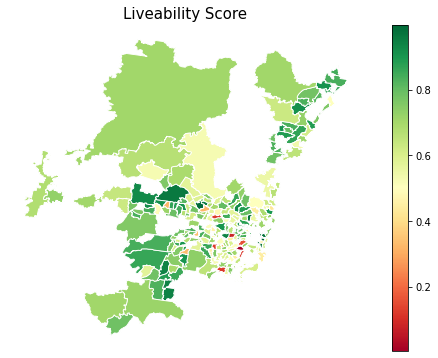

In [167]:
# MAIN CODE FOR TASK-2
sql="""

with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Contains(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,

1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Contains(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_NAME16"
ORDER BY sigmoid desc
;
"""
# Our Results
# results_df = query(conn,sql)
# results_df

# The common data between our result and sa2_data
# gdf = gpd.GeoDataFrame(results_df)
# gdf2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
# mg = gdf.reset_index().merge(gdf2, left_on = 'SA2_NAME16', right_on = 'SA2_NAME16') # Good
# mg 

# Greater Sydney Map
# gdf3 = gdf2[gdf2['GCC_NAME16']=='Greater Sydney'] 
# gdf3.plot(figsize=(10,10))
# gdf3

# Missing Rows Area
# df = pd.concat([mg.drop(columns=['index', 'hz','rz','az','cz','sz','sigmoid']), gdf3])
# gdf4 = df.drop_duplicates(keep=False)
# # df
# gdf4.plot()


q = query(conn,sql)

gdf = gpd.GeoDataFrame(q)

sa2_areas = gpd.read_file('SA2_2016_AUST/SA2_2016_AUST.shp')

merged = gdf.set_index('SA2_NAME16').join(sa2_areas.set_index('SA2_NAME16'))
# print(merged)

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Liveability Score', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged.plot(column='sigmoid',
            cmap='RdYlGn',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True, missing_kwds={
            "color": "lightgrey",
            "label": "Missing values",},)


In [168]:
# Should be getting 312
# In total, getting 33 less rows
# Neighbourhood dataset has 13 less rows than sa2_data
# Break_and enter dataset has 28 less rows than sa2_data
sql="""
with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Contains(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)

SELECT s."SA2_NAME16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,
1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Contains(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_NAME16"
ORDER BY sigmoid desc;

"""
query(conn,sql)

,SA2_NAME16,hz,rz,az,cz,sz,sigmoid
0,Bondi Junction - Waverly,4.006659,0.980595,1.571857,0.578344,0.042798,0.997585
1,Baulkham Hills (West) - Bella Vista,3.066007,0.753234,0.774132,0.087790,0.197065,0.991010
2,Randwick - South,3.053690,0.218501,0.677265,0.124888,0.029139,0.979239
3,Chatswood (East) - Artarmon,2.250011,0.752535,1.467748,0.673090,0.012578,0.978327
4,Double Bay - Bellevue Hill,2.742828,0.833471,0.649803,0.733774,0.095035,0.973074
...,...,...,...,...,...,...,...
223,Oatlands - Dundas Valley,0.374638,0.087331,0.274879,2.735103,0.004135,0.119822
224,Sutherland - Kirrawee,0.068588,0.152413,0.129558,2.627548,0.280496,0.119572
225,Monterey - Brighton-le-Sands - Kyeemagh,0.168389,0.057532,0.396601,2.718393,0.039047,0.113365
226,Burwood - Croydon,1.210133,0.804935,0.937105,5.487829,0.074427,0.078621


In [169]:

# Should be getting 312
# In total, getting 33 less rows
# Neighbourhood dataset has 13 less rows than sa2_data
# Break_and enter dataset has 28 less rows than sa2_data
sql="""
CREATE TABLE results
AS

with Health AS 
(SELECT avg(1000.0*bs."health_care_and_social_assistance"/n."population") AS mean,
stddev(1000.0*bs."health_care_and_social_assistance"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Retail AS
(SELECT avg(1000.0*bs."retail_trade"/n."population") AS mean,
stddev(1000.0*bs."retail_trade"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Accom AS
(SELECT avg(1000.0*bs."accommodation_and_food_services"/n."population") AS mean,
stddev(1000.0*bs."accommodation_and_food_services"/n."population") AS sd
FROM businessstats bs, neighbourhood n
WHERE bs."area_id" = n."area_id"),

Crime AS 
(SELECT AVG(q1) AS mean,
stddev(q1) AS sd
FROM ( SELECT AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")as q1
        FROM break_and_enter be join sa2_data s ON
        ST_Contains(s.geom,be.geom)
        GROUP BY s."SA2_NAME16") a ),
        
Schools AS 
(SELECT AVG(Schools) AS mean,
stddev(Schools) as sd 
FROM (SELECT 1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19")) AS Schools
    FROM school_catchments_combined sc, sa2_data s, neighbourhood n
    WHERE ST_Intersects(s.geom,sc.geom)
    AND s."SA2_MAIN16" = n."area_id"
    GROUP BY s."SA2_NAME16" ) b)


SELECT s."SA2_MAIN16",

abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd) AS HZ,

abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd) AS RZ,

abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd) AS AZ,

abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)) AS CZ,

abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd)) AS SZ,
1/(1+(exp(-((abs((1000.0*AVG(bs."health_care_and_social_assistance")/AVG(n."population"))-AVG(Health.mean))/AVG(Health.sd))
            +(abs((1000.0*AVG(bs."retail_trade")/AVG(n."population"))-AVG(Retail.mean))/AVG(Retail.sd))
            +(abs((1000.0*AVG(bs."accommodation_and_food_services")/AVG(n."population"))-AVG(Accom.mean))/AVG(Accom.sd))
            -(abs((AVG(be."ORIG_FID"*be."Shape_Area"/s."AREASQKM16")-AVG(Crime.mean))/AVG(Crime.sd)))
            +(abs((1000.0*COUNT(*)/(AVG(n."0-4")+AVG(n."5-9")+AVG(n."10-14")+AVG(n."15-19"))-AVG(Schools.mean))/AVG(Schools.sd))))))) AS Sigmoid

FROM sa2_data s, businessstats bs, break_and_enter be, neighbourhood n,school_catchments_combined sc, Health, Retail, Accom, crime, Schools
WHERE s."SA2_MAIN16" = bs."area_id"
AND bs."area_id" = n."area_id"
AND s."SA2_MAIN16" = n."area_id"
AND ST_Contains(s.geom,be.geom)
AND ST_Intersects(s.geom,sc.geom)
GROUP BY s."SA2_MAIN16"
ORDER BY sigmoid desc;

"""

#query(conn,sql)

query(conn, "select * from results") 



,SA2_MAIN16,hz,rz,az,cz,sz,sigmoid
0,118011341,4.006659,0.980595,1.571857,0.578344,0.042798,0.997585
1,115011291,3.066007,0.753234,0.774132,0.087790,0.197065,0.991010
2,118021570,3.053690,0.218501,0.677265,0.124888,0.029139,0.979239
3,121011398,2.250011,0.752535,1.467748,0.673090,0.012578,0.978327
4,118011343,2.742828,0.833471,0.649803,0.733774,0.095035,0.973074
...,...,...,...,...,...,...,...
223,125021478,0.374638,0.087331,0.274879,2.735103,0.004135,0.119822
224,128021538,0.068588,0.152413,0.129558,2.627548,0.280496,0.119572
225,119041380,0.168389,0.057532,0.396601,2.718393,0.039047,0.113365
226,120031391,1.210133,0.804935,0.937105,5.487829,0.074427,0.078621


In [170]:
sql = """
select * 
from results R join neighbourhood N
ON R."SA2_MAIN16" = N."area_id";
"""

query(conn, sql)

,SA2_MAIN16,hz,rz,az,cz,sz,sigmoid,area_id,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,118011341,4.006659,0.980595,1.571857,0.578344,0.042798,0.997585,118011341,252.3,18314,4379,3685,56457.0,2630,1077,896,710,686
1,115011291,3.066007,0.753234,0.774132,0.087790,0.197065,0.991010,115011291,1096.3,21416,5244,4674,53703.0,2521,1236,1511,1370,1583
2,118021570,3.053690,0.218501,0.677265,0.124888,0.029139,0.979239,118021570,337.3,14238,3922,1402,58849.0,2459,785,697,526,593
3,121011398,2.250011,0.752535,1.467748,0.673090,0.012578,0.978327,121011398,506.8,30778,9711,5358,51040.0,2542,2000,1846,1389,1517
4,118011343,2.742828,0.833471,0.649803,0.733774,0.095035,0.973074,118011343,471.4,27009,9187,5016,72578.0,2883,1344,1257,1233,1239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,125021478,0.374638,0.087331,0.274879,2.735103,0.004135,0.119822,125021478,607.6,18791,4029,1544,45233.0,1539,1262,1234,1013,1160
224,128021538,0.068588,0.152413,0.129558,2.627548,0.280496,0.119572,128021538,775.5,21760,6924,2086,53378.0,1809,1538,1242,1081,1033
225,119041380,0.168389,0.057532,0.396601,2.718393,0.039047,0.113365,119041380,338.0,14936,4649,1363,49203.0,1960,881,765,718,678
226,120031391,1.210133,0.804935,0.937105,5.487829,0.074427,0.078621,120031391,449.3,26524,7053,3477,40592.0,2163,1155,1033,988,1528


In [171]:
conn.close()
db.dispose()